In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)
from itertools import product
import joblib  # or use pickle

### Load the data

In [2]:
period = 140

In [6]:
data_normal, RF_ab, LF_ab, LH_ab, RH_ab = prepare_datasets(period, generate_data_set)

In [7]:
data_for_train = np.vstack((data_normal, RF_ab, LF_ab, LH_ab,RH_ab))
# RF LF LH RH 
scalers = []
slices = [(16, 20), (20, 24), (24, 28), (28, 32)]

for idx, (start, end) in enumerate(slices):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    segment = data_for_train[:, start:end]
    data_for_train[:, start:end] = scaler.fit_transform(segment)
    
    # Save the scaler
    joblib.dump(scaler, f'scaler_{idx}.save')
    scalers.append(scaler)

#### Combine the normal and abnormal data

In [8]:
# Example usage
train_ad, test_ad = generate_split(0, 50)
train_lose, test_lose = generate_split(51, 171)

train_id =  np.concatenate((train_ad, train_lose))
test_id = np.concatenate((test_ad, test_lose))

np.random.seed(42) 
np.random.shuffle(train_id)
np.random.shuffle(test_id)


In [13]:
train_set, test_set = generate_data_sets(train_id, test_id, data_for_train)

### K-fold id test

In [49]:
ids = np.arange(20)  # Your full ID list
for train_ids, test_ids in k_fold_split(ids, k=5):
    print("Train:", train_ids[:], "...", "Test:", test_ids[:])

Train: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ... Test: [0 1 2 3]
Train: [ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19] ... Test: [4 5 6 7]
Train: [ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19] ... Test: [ 8  9 10 11]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19] ... Test: [12 13 14 15]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] ... Test: [16 17 18 19]


### Training and hyper-parameter optimization

In [33]:
# take the training process for RF limb as an example
# Hyperparameter ranges
spectral_radius_range = [0.8, 0.85, 0.9, 0.95]
sparsity_range = [0.1, 0.2, 0.3, 0.4]
leak_rate_range = [0.3, 0.6, 0.9]
reservoir_size_range = [60, 80, 100, 120, 140, 160]

best_per_iter = []
# generate the k-fold train and val sets
for fold_idx, (train_ids, val_ids) in enumerate(k_fold_split(train_id, k=5), start=1):
    train_set, val_set = generate_data_sets(train_ids, val_ids, data_for_train)
    
    print(f"\n========== Fold {fold_idx}/5 ==========")
    print("Train IDs (first 5):", train_ids[:5], "...")
    print("Val IDs (first 5):", val_ids[:5])
    # generate the train and val set
    train_inputs = train_set[:, 16:20]
    train_targets = train_set[:, 32:34]
    val_inputs = val_set[:, 16:20]
    val_targets = val_set[:, 32:34]

    # Storage: one row per reservoir size, columns = [MSE_Y, spectral_radius, sparsity, leak_rate]
    best_per_size = {}
    
    for spectral_radius, sparsity, leak_rate, reservoir_size in product(
        spectral_radius_range, sparsity_range, leak_rate_range, reservoir_size_range
    ):
        esn = ESN(
            input_size=4,
            reservoir_size=reservoir_size,
            output_size=2,
            spectral_radius=spectral_radius,
            sparsity=sparsity,
            leak_rate=leak_rate,
            seed=42
        )
    
        esn.fit(train_inputs, train_targets)
        predictions = esn.predict(val_inputs)
    
        mse_y = mean_squared_error(val_targets[:, 1], predictions[:, 1])
    
        # If it's the first time or current MSE is better, update record
        if (reservoir_size not in best_per_size) or (mse_y < best_per_size[reservoir_size][0]):
            best_per_size[reservoir_size] = [mse_y, spectral_radius, sparsity, leak_rate]
    
    # Convert to matrix
    result_matrix = []
    for res_size in sorted(best_per_size.keys()):
        row = [res_size] + best_per_size[res_size]  # [reservoir_size, mse_y, sr, sparsity, leak]
        result_matrix.append(row)
    
    result_matrix = np.array(result_matrix)
    best_per_iter.append(result_matrix)
    # Print the results
    print("\nReservoir Size | Best MSE_Y | Spectral Radius | Sparsity | Leak Rate")
    for row in result_matrix:
        print(f"{int(row[0]):14} | {row[1]:10.4f} | {row[2]:15} | {row[3]:8} | {row[4]:9}")
    


========== Fold 1/5 ==========
Train IDs (first 5): [ 22 124 154   8  37] ...
Val IDs (first 5): [129  76  97 111  12]

Reservoir Size | Best MSE_Y | Spectral Radius | Sparsity | Leak Rate
            60 |     0.0172 |             0.8 |      0.3 |       0.6
            80 |     0.0158 |            0.95 |      0.1 |       0.6
           100 |     0.0147 |             0.8 |      0.1 |       0.6
           120 |     0.0145 |             0.8 |      0.3 |       0.9
           140 |     0.0136 |             0.8 |      0.2 |       0.6
           160 |     0.0131 |             0.8 |      0.1 |       0.6

========== Fold 2/5 ==========
Train IDs (first 5): [129  76  97 111  12] ...
Val IDs (first 5): [ 22 124 154   8  37]

Reservoir Size | Best MSE_Y | Spectral Radius | Sparsity | Leak Rate
            60 |     0.0164 |             0.8 |      0.2 |       0.6
            80 |     0.0153 |            0.95 |      0.1 |       0.6
           100 |     0.0141 |             0.8 |      0.1 |       0.6

In [45]:
# Hyperparameter ranges
spectral_radius_range = [0.8, 0.85, 0.9, 0.95]
sparsity_range = [0.1, 0.2, 0.3, 0.4]
leak_rate_range = [0.3, 0.6, 0.9]
reservoir_size_range = [60, 80, 100, 120, 140, 160]

best_per_iter = []
best_esn_per_iter = []

# Generate the k-fold train and val sets
for fold_idx, (train_ids, val_ids) in enumerate(k_fold_split(train_id, k=5), start=1):
    train_set, val_set = generate_data_sets(train_ids, val_ids, data_for_train)
    
    print(f"\n========== Fold {fold_idx}/5 ==========")
    print("Train IDs (first 5):", train_ids[:5], "...")
    print("Val IDs (first 5):", val_ids[:5])

    train_inputs = train_set[:, 16:20]
    train_targets = train_set[:, 32:34]
    val_inputs = val_set[:, 16:20]
    val_targets = val_set[:, 32:34]

    best_per_size = {}
    esn_row_list = [] 
    for spectral_radius, sparsity, leak_rate, reservoir_size in product(
        spectral_radius_range, sparsity_range, leak_rate_range, reservoir_size_range
    ):
        esn = ESN(
            input_size=4,
            reservoir_size=reservoir_size,
            output_size=2,
            spectral_radius=spectral_radius,
            sparsity=sparsity,
            leak_rate=leak_rate,
            seed=42
        )

        esn.fit(train_inputs, train_targets)
        predictions = esn.predict(val_inputs)


        alpha = 0.7  # weight for column 2
        mse_col1 = mean_squared_error(val_targets[:, 0], predictions[:, 0])
        mse_col2 = mean_squared_error(val_targets[:, 1], predictions[:, 1])
        mse = alpha * mse_col2 + (1 - alpha) * mse_col1
        # Full MSE across both output dimensions
        # mse = mean_squared_error(val_targets, predictions)

        if (reservoir_size not in best_per_size) or (mse < best_per_size[reservoir_size][0]):
            best_per_size[reservoir_size] = [mse, spectral_radius, sparsity, leak_rate]

    result_matrix = []
    for res_size in sorted(best_per_size.keys()):
        row = [res_size] + best_per_size[res_size]
        result_matrix.append(row)

    result_matrix = np.array(result_matrix)
    best_per_iter.append(result_matrix)

    print("\nReservoir Size | Best MSE   | Spectral Radius | Sparsity | Leak Rate")
    for row in result_matrix:
        print(f"{int(row[0]):14} | {row[1]:10.4f} | {row[2]:15} | {row[3]:8} | {row[4]:9}")


========== Fold 1/5 ==========
Train IDs (first 5): [ 98  58 159  21  65] ...
Val IDs (first 5): [ 68 168 135 170   4]

Reservoir Size | Best MSE   | Spectral Radius | Sparsity | Leak Rate
            60 |     0.0841 |             0.8 |      0.2 |       0.6
            80 |     0.0746 |            0.95 |      0.1 |       0.6
           100 |     0.0731 |             0.8 |      0.2 |       0.6
           120 |     0.0688 |             0.8 |      0.4 |       0.3
           140 |     0.0661 |             0.8 |      0.1 |       0.6
           160 |     0.0629 |             0.8 |      0.1 |       0.3

========== Fold 2/5 ==========
Train IDs (first 5): [ 68 168 135 170   4] ...
Val IDs (first 5): [ 98  58 159  21  65]

Reservoir Size | Best MSE   | Spectral Radius | Sparsity | Leak Rate
            60 |     0.0837 |             0.8 |      0.2 |       0.6
            80 |     0.0771 |            0.95 |      0.1 |       0.6
           100 |     0.0743 |             0.8 |      0.3 |       0.6

In [58]:
best_per_iter[2]

array([[ 60.        ,   0.08146307,   0.8       ,   0.2       ,
          0.6       ],
       [ 80.        ,   0.07175779,   0.95      ,   0.1       ,
          0.6       ],
       [100.        ,   0.07041452,   0.8       ,   0.3       ,
          0.6       ],
       [120.        ,   0.06701145,   0.8       ,   0.4       ,
          0.6       ],
       [140.        ,   0.06262329,   0.9       ,   0.3       ,
          0.3       ],
       [160.        ,   0.06025481,   0.8       ,   0.2       ,
          0.3       ]])

In [60]:
# store the best ESN

spectral_radius_range = [0.8, 0.85, 0.9, 0.95]
sparsity_range = [0.1, 0.2, 0.3, 0.4]
leak_rate_range = [0.3, 0.6, 0.9]
reservoir_size_range = [60, 80, 100, 120, 140, 160]

best_per_iter = []           # stores result matrix per fold
best_esn_per_iter = []       # stores ESN models per fold

# Generate the k-fold train and val sets
for fold_idx, (train_ids, val_ids) in enumerate(k_fold_split(train_id, k=5), start=1):
    train_set, val_set = generate_data_sets(train_ids, val_ids, data_for_train)
    
    print(f"\n========== Fold {fold_idx}/5 ==========")
    print("Train IDs (first 5):", train_ids[:5], "...")
    print("Val IDs (first 5):", val_ids[:5])

    train_inputs = train_set[:, 16:20]
    train_targets = train_set[:, 32:34]
    val_inputs = val_set[:, 16:20]
    val_targets = val_set[:, 32:34]

    best_per_size = {}
    best_esn_for_size = {}

    for spectral_radius, sparsity, leak_rate, reservoir_size in product(
        spectral_radius_range, sparsity_range, leak_rate_range, reservoir_size_range
    ):
        esn = ESN(
            input_size=4,
            reservoir_size=reservoir_size,
            output_size=2,
            spectral_radius=spectral_radius,
            sparsity=sparsity,
            leak_rate=leak_rate,
            seed=42
        )

        esn.fit(train_inputs, train_targets)
        predictions = esn.predict(val_inputs)

        alpha = 0.7  # weight for column 2
        mse_col1 = mean_squared_error(val_targets[:, 0], predictions[:, 0])
        mse_col2 = mean_squared_error(val_targets[:, 1], predictions[:, 1])
        mse = alpha * mse_col2 + (1 - alpha) * mse_col1

        if (reservoir_size not in best_per_size) or (mse < best_per_size[reservoir_size][0]):
            best_per_size[reservoir_size] = [mse, spectral_radius, sparsity, leak_rate]
            # retrain and store this best ESN
            best_esn = ESN(
                input_size=4,
                reservoir_size=reservoir_size,
                output_size=2,
                spectral_radius=spectral_radius,
                sparsity=sparsity,
                leak_rate=leak_rate,
                seed=42
            )
            best_esn.fit(train_inputs, train_targets)
            best_esn_for_size[reservoir_size] = best_esn

    result_matrix = []
    esn_row_list = []

    for res_size in sorted(best_per_size.keys()):
        row = [res_size] + best_per_size[res_size]  # [res_size, mse, sr, sparsity, leak]
        result_matrix.append(row)
        esn_row_list.append(best_esn_for_size[res_size])

    result_matrix = np.array(result_matrix)
    best_per_iter.append(result_matrix)
    best_esn_per_iter.append(esn_row_list)

    print("\nReservoir Size | Best MSE   | Spectral Radius | Sparsity | Leak Rate")
    for row in result_matrix:
        print(f"{int(row[0]):14} | {row[1]:10.4f} | {row[2]:15} | {row[3]:8} | {row[4]:9}")



========== Fold 1/5 ==========
Train IDs (first 5): [ 98  58 159  21  65] ...
Val IDs (first 5): [ 68 168 135 170   4]

Reservoir Size | Best MSE   | Spectral Radius | Sparsity | Leak Rate
            60 |     0.0841 |             0.8 |      0.2 |       0.6
            80 |     0.0746 |            0.95 |      0.1 |       0.6
           100 |     0.0731 |             0.8 |      0.2 |       0.6
           120 |     0.0688 |             0.8 |      0.4 |       0.3
           140 |     0.0661 |             0.8 |      0.1 |       0.6
           160 |     0.0629 |             0.8 |      0.1 |       0.3

========== Fold 2/5 ==========
Train IDs (first 5): [ 68 168 135 170   4] ...
Val IDs (first 5): [ 98  58 159  21  65]

Reservoir Size | Best MSE   | Spectral Radius | Sparsity | Leak Rate
            60 |     0.0837 |             0.8 |      0.2 |       0.6
            80 |     0.0771 |            0.95 |      0.1 |       0.6
           100 |     0.0743 |             0.8 |      0.3 |       0.6

#### Performance in the test set

In [63]:
best_esn_per_iter[0]

In [59]:
# Iterate over each fold's best_per_size matrix
for fold_idx, fold_matrix in enumerate(best_esn_per_iter, start=1):
    print(f"\n--- Fold {fold_idx} ---")
    test_results = []
    for row_idx, row in enumerate(fold_matrix):
        


--- Fold 1 ---
[[ 60.           0.08409756   0.8          0.2          0.6       ]
 [ 80.           0.07460045   0.95         0.1          0.6       ]
 [100.           0.07308413   0.8          0.2          0.6       ]
 [120.           0.06882204   0.8          0.4          0.3       ]
 [140.           0.06610273   0.8          0.1          0.6       ]
 [160.           0.06287137   0.8          0.1          0.3       ]]

--- Fold 2 ---
[[ 60.           0.08368511   0.8          0.2          0.6       ]
 [ 80.           0.07713636   0.95         0.1          0.6       ]
 [100.           0.07425273   0.8          0.3          0.6       ]
 [120.           0.07089471   0.8          0.2          0.3       ]
 [140.           0.06744863   0.8          0.1          0.3       ]
 [160.           0.06478641   0.85         0.2          0.3       ]]

--- Fold 3 ---
[[ 60.           0.08146307   0.8          0.2          0.6       ]
 [ 80.           0.07175779   0.95         0.1          0.6       

In [64]:
test_inputs = test_set[:, 16:20]
test_targets = test_set[:, 32:34]

alpha = 0.7  # importance weight for col 2
test_overall_res = []

# Iterate over each fold's result matrix and ESNs
for fold_idx, (fold_matrix, fold_esns) in enumerate(zip(best_per_iter, best_esn_per_iter), start=1):
    print(f"\n--- Fold {fold_idx} ---")
    test_results = []

    for row_idx, row in enumerate(fold_matrix):
        # Retrieve ESN and hyperparams
        reservoir_size = int(row[0])
        val_mse = row[1]
        spectral_radius = row[2]
        sparsity = row[3]
        leak_rate = row[4]

        esn = fold_esns[row_idx]  # retrieve ESN trained during validation

        # Predict on test set
        predictions = esn.predict(test_inputs)

        # Compute weighted test MSE
        mse_col1 = mean_squared_error(test_targets[:, 0], predictions[:, 0])
        mse_col2 = mean_squared_error(test_targets[:, 1], predictions[:, 1])
        test_mse = alpha * mse_col2 + (1 - alpha) * mse_col1

        # Record result
        test_results.append([
            fold_idx, row_idx,
            reservoir_size, val_mse, test_mse,
            spectral_radius, sparsity, leak_rate
        ])

    # Store per-fold results
    test_overall_res.append(np.array(test_results))

    # Print per-fold summary
    print("\nFold | Row | Reservoir Size | Val MSE  | Test MSE | Spectral Radius | Sparsity | Leak Rate")
    for row in test_results:
        print(f"{int(row[0]):4} | {int(row[1]):3} | {int(row[2]):14} | {row[3]:8.4f} | {row[4]:8.4f} |"
              f" {row[5]:15} | {row[6]:8} | {row[7]:9}")

    


--- Fold 1 ---

Fold | Row | Reservoir Size | Val MSE  | Test MSE | Spectral Radius | Sparsity | Leak Rate
   1 |   0 |             60 |   0.0841 |   0.0820 |             0.8 |      0.2 |       0.6
   1 |   1 |             80 |   0.0746 |   0.0758 |            0.95 |      0.1 |       0.6
   1 |   2 |            100 |   0.0731 |   0.0718 |             0.8 |      0.2 |       0.6
   1 |   3 |            120 |   0.0688 |   0.0675 |             0.8 |      0.4 |       0.3
   1 |   4 |            140 |   0.0661 |   0.0629 |             0.8 |      0.1 |       0.6
   1 |   5 |            160 |   0.0629 |   0.0617 |             0.8 |      0.1 |       0.3

--- Fold 2 ---

Fold | Row | Reservoir Size | Val MSE  | Test MSE | Spectral Radius | Sparsity | Leak Rate
   2 |   0 |             60 |   0.0837 |   0.0821 |             0.8 |      0.2 |       0.6
   2 |   1 |             80 |   0.0771 |   0.0763 |            0.95 |      0.1 |       0.6
   2 |   2 |            100 |   0.0743 |   0.0701 |     

#### Train with PSO

In [66]:
from pyswarms.single import GlobalBestPSO

In [67]:
def pso_objective_function(particles, train_inputs, train_targets, val_inputs, val_targets):
    results = []

    for p in particles:
        reservoir_size = int(p[0])
        spectral_radius = p[1]
        sparsity = p[2]
        leak_rate = p[3]

        try:
            esn = ESN(
                input_size=4,
                reservoir_size=reservoir_size,
                output_size=2,
                spectral_radius=spectral_radius,
                sparsity=sparsity,
                leak_rate=leak_rate,
                seed=42
            )
            esn.fit(train_inputs, train_targets)
            predictions = esn.predict(val_inputs)

            alpha = 0.7
            mse1 = mean_squared_error(val_targets[:, 0], predictions[:, 0])
            mse2 = mean_squared_error(val_targets[:, 1], predictions[:, 1])
            weighted_mse = alpha * mse2 + (1 - alpha) * mse1

        except Exception as e:
            weighted_mse = 1e6  # large penalty for failed ESN

        results.append(weighted_mse)

    return np.array(results)

In [69]:
# Define bounds
# Format: [min], [max]
for fold_idx, (train_ids, val_ids) in enumerate(k_fold_split(train_id, k=5), start=1):
    train_set, val_set = generate_data_sets(train_ids, val_ids, data_for_train)
    
    print(f"\n========== Fold {fold_idx}/5 ==========")
    print("Train IDs (first 5):", train_ids[:5], "...")
    print("Val IDs (first 5):", val_ids[:5])

    train_inputs = train_set[:, 16:20]
    train_targets = train_set[:, 32:34]
    val_inputs = val_set[:, 16:20]
    val_targets = val_set[:, 32:34]


bounds = (
    [60,  0.8,  0.1, 0.3],   # min values for: reservoir_size, sr, sparsity, leak_rate
    [160, 0.95, 0.4, 0.9]    # max values
)

optimizer = GlobalBestPSO(
    n_particles=20,
    dimensions=4,
    options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
    bounds=bounds
)

best_cost, best_pos = optimizer.optimize(
    pso_objective_function,
    iters=30,
    train_inputs=train_inputs,
    train_targets=train_targets,
    val_inputs=val_inputs,
    val_targets=val_targets
)

2025-06-05 14:05:20,086 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}



========== Fold 1/5 ==========
Train IDs (first 5): [ 98  58 159  21  65] ...
Val IDs (first 5): [ 68 168 135 170   4]

========== Fold 2/5 ==========
Train IDs (first 5): [ 68 168 135 170   4] ...
Val IDs (first 5): [ 98  58 159  21  65]

========== Fold 3/5 ==========
Train IDs (first 5): [ 68 168 135 170   4] ...
Val IDs (first 5): [ 42  29 165  40  38]

========== Fold 4/5 ==========
Train IDs (first 5): [ 68 168 135 170   4] ...
Val IDs (first 5): [ 50  92  15  10 124]

========== Fold 5/5 ==========
Train IDs (first 5): [ 68 168 135 170   4] ...
Val IDs (first 5): [ 66 132 119 162 161]


pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|30/30, best_cost=0.0598
2025-06-05 14:08:26,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.05982840145228473, best pos: [143.54099007   0.88148103   0.20967311   0.42978174]


In [70]:
best_res_size = int(best_pos[0])
best_sr = best_pos[1]
best_sp = best_pos[2]
best_lk = best_pos[3]

final_esn = ESN(
    input_size=4,
    reservoir_size=best_res_size,
    output_size=2,
    spectral_radius=best_sr,
    sparsity=best_sp,
    leak_rate=best_lk,
    seed=42
)
final_esn.fit(train_inputs, train_targets)

test_inputs = test_set[:, 16:20]
test_targets = test_set[:, 32:34]

grf_predicted = final_esn.predict(test_inputs)

In [71]:


grf_predicted = final_esn.predict(test_inputs)

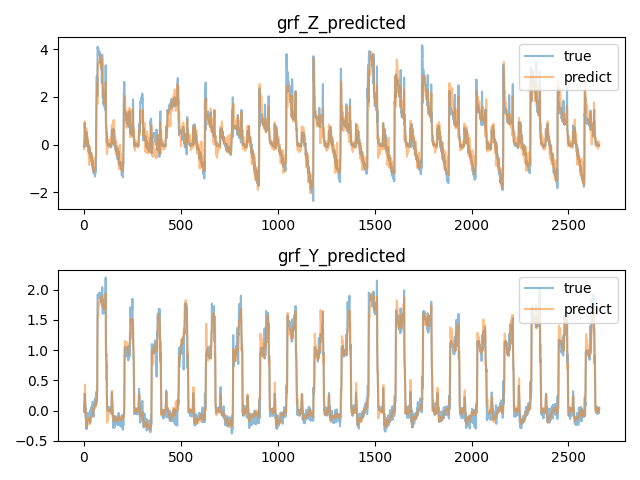

In [72]:
plt.close('all')
plt.subplot(2,1,1)
plt.plot(test_targets[:,0], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,0], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Z_predicted')

plt.subplot(2,1,2)
plt.plot(test_targets[:,1], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,1], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Y_predicted')
plt.tight_layout()

In [39]:
def k_fold_split(id_list, k=5):
    """
    Generator that yields train and test splits for k-fold cross-validation.

    Parameters:
        id_list (list or array-like): List of IDs to split.
        k (int): Number of folds.
        seed (int, optional): Random seed for reproducibility.

    Yields:
        train_ids, test_ids: Two NumPy arrays for the current fold.
    """
    id_array = np.array(id_list)
    # FORBID THE SHUFFLE
    fold_size = len(id_array) // k

    for i in range(k):
        test_start = i * fold_size
        test_end = (i + 1) * fold_size if i < k - 1 else len(id_array)
        test_ids = id_array[test_start:test_end]
        train_ids = np.concatenate([id_array[:test_start], id_array[test_end:]])
        yield train_ids, test_ids

In [3]:
def prepare_datasets(period, generate_data_set, 
                     normal_path='data_for_train.csv',
                     rf_path='RF_limb.npy',
                     lf_path='LF_limb.npy',
                     lh_path='LH_limb.npy',
                     rh_path='RH_limb.npy'):
    """
    Load and preprocess datasets for normal and four abnormal limb conditions.

    Parameters:
        period (int): Number of time steps per sample.
        generate_data_set (function): Function to segment dataset by selected indices.
        normal_path (str): Path to normal data CSV file.
        rf_path (str): Path to RF abnormal data (.npy).
        lf_path (str): Path to LF abnormal data (.npy).
        lh_path (str): Path to LH abnormal data (.npy).
        rh_path (str): Path to RH abnormal data (.npy).

    Returns:
        data_normal, RF_ab, LF_ab, LH_ab, RH_ab (tuple of arrays)
    """

    np.random.seed(42)

    # Load data
    data_normal = np.loadtxt(normal_path, delimiter=',')
    RF_ab = np.load(rf_path)
    LF_ab = np.load(lf_path)
    LH_ab = np.load(lh_path)
    RH_ab = np.load(rh_path)[period*3:, :]  # Crop first 3 periods

    # Process normal data
    select_id_normal = np.arange(data_normal.shape[0] // period)
    np.random.shuffle(select_id_normal)
    data_normal = generate_data_set(select_id_normal, data_normal)

    # Process RF
    select_id_RF = np.arange(RF_ab.shape[0] // period)
    np.random.shuffle(select_id_RF)
    RF_ab = generate_data_set(select_id_RF[:30], RF_ab)

    # Process LF
    select_id_LF = np.arange(LF_ab.shape[0] // period)
    np.random.shuffle(select_id_LF)
    LF_ab = generate_data_set(select_id_LF[:30], LF_ab)

    # Process LH
    select_id_LH = np.arange(LH_ab.shape[0] // period)
    np.random.shuffle(select_id_LH)
    LH_ab = generate_data_set(select_id_LH[:30], LH_ab)

    # Process RH
    select_id_RH = np.arange(RH_ab.shape[0] // period)
    np.random.shuffle(select_id_RH)
    RH_ab = generate_data_set(select_id_RH[:30], RH_ab)

    return data_normal, RF_ab, LF_ab, LH_ab, RH_ab

In [4]:
def generate_data_set(train_id, data_for_train, period=140):
    train_set = []
    for i in train_id:
        train_set.append(data_for_train[period * i: period * (i + 1), :])
    return np.vstack(train_set)

In [5]:
def generate_split(start, end):
    """
    Split the ID range [start, end] into training and test sets (80/20).
    
    Returns:
    - train_set: array of training IDs
    - test_set: array of testing IDs
    """
    ids = np.arange(start, end + 1)
    np.random.shuffle(ids)

    total_size = len(ids)
    train_size = int(0.9 * total_size)

    train_set = ids[:train_size]
    test_set = ids[train_size:]

    return train_set, test_set

In [12]:
def generate_data_sets(train_id, test_id, data_for_train, period=140):
    # Initialize empty lists to hold the subsets
    train_set = []
    test_set = []

    # Populate train_set
    for i in train_id:
        train_set.append(data_for_train[period * i: period * (i + 1), :])

    # Populate test_set
    for i in test_id:
        test_set.append(data_for_train[period * i: period * (i + 1), :])

    return np.vstack(train_set), np.vstack(test_set)


In [32]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, 
                 spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.leak_rate = leak_rate

        # Input weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_size))

        # Reservoir weights
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(*W.shape) < sparsity
        W *= mask  # sparsify
        eigvals = np.max(np.abs(np.linalg.eigvals(W)))
        self.Wres = W * (spectral_radius / eigvals)

        # Output weights (trained later)
        self.Wout = None

        self.state = np.zeros((reservoir_size,))

    def _update_state(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.Wres, self.state)
        new_state = np.tanh(pre_activation)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state
        return self.state

    def fit(self, inputs, targets, washout=50, ridge_lambda=1e-6):
        states = []
        for u in inputs:
            state = self._update_state(u)
            states.append(state)

        states = np.array(states)
        states_washed = states[washout:]
        targets_washed = targets[washout:]

        # Add bias term
        extended_states = np.hstack([states_washed, np.ones((states_washed.shape[0], 1))])
        
        # Ridge regression
        self.Wout = np.dot(np.linalg.pinv(extended_states), targets_washed)

    def predict(self, inputs):
        outputs = []
        for u in inputs:
            state = self._update_state(u)
            extended_state = np.concatenate([state, [1]])  # Add bias
            y = np.dot(extended_state, self.Wout)
            outputs.append(y)
        return np.array(outputs)